# Dynamic Portfolio Optimization

Optimization Algorithms ->

1) Hierarchical Clustering + MVO Optimization

2) Black Litterman Investor Views + Hierarchical Clustering

3) Hierarchical Clustering + HRP

# Importing Libraries

In [ ]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
!pip install seaborn

In [ ]:
!pip install yfinance pandas numpy scipy beautifulsoup4 textblob requests

In [ ]:
!pip install riskfolio-lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.8/314.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 13.2 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage,fcluster
from pypfopt import EfficientFrontier, objective_functions
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return
from pypfopt.discrete_allocation import DiscreteAllocation

In [ ]:
from datetime import datetime,timedelta
from textblob import TextBlob
import requests
from bs4 import BeautifulSoup
from scipy.optimize import minimize

In [ ]:
from pypfopt import BlackLittermanModel,black_litterman,risk_models,expected_returns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Top Stocks Selection Function

Companies are selected based on technical indicators , fundamental ratios and public sentiment / news headlines.

Train data is of past 1 year.



In [ ]:
class StockSelector:

    def __init__(self, nse_symbols):
        self.symbols = nse_symbols
        self.data = {}
        self.scores = {}

    def fetch_historical_data(self, period='1y'):
        """Fetch historical price data for all symbols"""
        for symbol in self.symbols:
            try:
                stock = yf.Ticker(symbol)
                self.data[symbol] = stock.history(period=period)
            except Exception as e:
                print(f"Error fetching data for {symbol}: {e}")

    def calculate_technical_metrics(self):
        """Calculate technical indicators for each stock"""
        for symbol, df in self.data.items():
            try:
                # Calculate daily returns
                df['Returns'] = df['Close'].pct_change()

                # Volatility (20-day)
                df['Volatility'] = df['Returns'].rolling(window=20).std()

                # Moving averages
                df['MA50'] = df['Close'].rolling(window=50).mean()
                df['MA200'] = df['Close'].rolling(window=200).mean()

                # RSI (14-day)
                delta = df['Close'].diff()
                gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
                loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
                rs = gain / loss
                df['RSI'] = 100 - (100 / (1 + rs))

                # Store the latest metrics in scores
                self.scores[symbol] = {
                    'volatility': df['Volatility'].iloc[-1],
                    'momentum': (df['Close'].iloc[-1] / df['Close'].iloc[-20]) - 1,
                    'rsi': df['RSI'].iloc[-1]
                }

            except Exception as e:
                print(f"Error calculating metrics for {symbol}: {e}")

    def fetch_fundamental_data(self):
        """Fetch fundamental data for each stock"""
        for symbol in self.symbols:
            try:
                stock = yf.Ticker(symbol)
                info = stock.info

                self.scores[symbol].update({
                    'pe_ratio': info.get('forwardPE', 0),
                    'debt_to_equity': info.get('debtToEquity', 0),
                    'roe': info.get('returnOnEquity', 0) * 100 if info.get('returnOnEquity') else 0,
                    'market_cap': info.get('marketCap', 0)
                })

            except Exception as e:
                print(f"Error fetching fundamental data for {symbol}: {e}")

    def calculate_sentiment(self):
        """Calculate sentiment score from news headlines"""
        for symbol in self.symbols:
            try:
                # Get news headlines (simplified example)
                url = f"https://www.google.com/search?q={symbol}+stock+news"
                headers = {'User-Agent': 'Mozilla/5.0'}
                response = requests.get(url, headers=headers)
                soup = BeautifulSoup(response.text, 'html.parser')
                headlines = soup.find_all('h3')

                # Calculate average sentiment
                sentiments = []
                for headline in headlines[:10]:  # Consider top 5 headlines
                    blob = TextBlob(headline.text)
                    sentiments.append(blob.sentiment.polarity)

                self.scores[symbol]['sentiment'] = np.mean(sentiments) if sentiments else 0

            except Exception as e:
                print(f"Error calculating sentiment for {symbol}: {e}")

    def calculate_final_scores(self):
        """Calculate final scores and rank stocks"""
        weights = {
            'volatility': -0.2,    # Lower is better
            'momentum': 0.2,
            'rsi': 0.15,
            'pe_ratio': -0.15,     # Lower is better
            'debt_to_equity': -0.1, # Lower is better
            'roe': 0.1,
            'sentiment': 0.1
        }

        # Normalize scores
        metrics = list(weights.keys())
        normalized_scores = {symbol: {} for symbol in self.symbols}

        for metric in metrics:
            values = [self.scores[symbol][metric] for symbol in self.symbols]
            min_val = min(values)
            max_val = max(values)
            range_val = max_val - min_val if max_val != min_val else 1

            for symbol in self.symbols:
                normalized_scores[symbol][metric] = (self.scores[symbol][metric] - min_val) / range_val

        # Calculate weighted scores
        final_scores = {}
        for symbol in self.symbols:
            score = sum(normalized_scores[symbol][metric] * weights[metric]
                       for metric in metrics)
            final_scores[symbol] = score

        return dict(sorted(final_scores.items(), key=lambda x: x[1], reverse=True))




def main():
    # Example usage
    # nse_symbols = [
    #                'BHARTIARTL.NS', 'LTIM.NS', 'HDFCLIFE.NS', 'NTPC.NS', 'MARUTI.NS',
    #                'NESTLEIND.NS', 'BAJFINANCE.NS', 'KOTAKBANK.NS', 'TATASTEEL.NS',
    #                'ONGC.NS', 'BAJAJ-AUTO.NS', 'LT.NS', 'ITC.NS', 'TCS.NS', 'BRITANNIA.NS',
    #                'SHRIRAMFIN.NS', 'ADANIENT.NS', 'CIPLA.NS', 'WIPRO.NS', 'INDUSINDBK.NS',
    #                'ULTRACEMCO.NS', 'TATACONSUM.NS', 'BAJAJFINSV.NS', 'RELIANCE.NS',
    #                'HEROMOTOCO.NS', 'COALINDIA.NS', 'TITAN.NS', 'HINDALCO.NS',
    #                'APOLLOHOSP.NS','TECHM.NS','DRREDDY.NS','DIVISLAB.NS','EICHERMOT.NS','BPCL.NS','SBILIFE.NS',
    #                'LTIM.NS','GRASIM.NS','JSWSTEEL.NS','ASIANPAINT.NS','POWERGRID.NS','ADANIPORTS.NS','M&M.NS',
    #                'TATAMOTORS.NS','SUNPHARMA.NS','AXISBANK.NS','HCLTECH.NS','HINDUNILVR.NS','INFY.NS','SBIN.NS',
    #                'ICICIBANK.NS','HDFCBANK.NS'
    # ]
    nse_symbols = [
                   'BHARTIARTL.NS', 'LTIM.NS', 'HDFCLIFE.NS', 'NTPC.NS', 'MARUTI.NS',
                   'NESTLEIND.NS', 'BAJFINANCE.NS', 'KOTAKBANK.NS', 'TATASTEEL.NS',
                   'ONGC.NS', 'BAJAJ-AUTO.NS', 'LT.NS', 'ITC.NS', 'TCS.NS', 'BRITANNIA.NS',
                   'ADANIENT.NS', 'CIPLA.NS', 'WIPRO.NS', 'INDUSINDBK.NS',
                   'ULTRACEMCO.NS', 'TATACONSUM.NS', 'BAJAJFINSV.NS', 'RELIANCE.NS',
                   'HEROMOTOCO.NS', 'COALINDIA.NS', 'TITAN.NS', 'HINDALCO.NS',
                   'APOLLOHOSP.NS','TECHM.NS','DRREDDY.NS','DIVISLAB.NS','EICHERMOT.NS','BPCL.NS','SBILIFE.NS',
                   'LTIM.NS','GRASIM.NS','JSWSTEEL.NS','ASIANPAINT.NS','POWERGRID.NS','ADANIPORTS.NS','M&M.NS',
                   'TATAMOTORS.NS','SUNPHARMA.NS','AXISBANK.NS','HCLTECH.NS','HINDUNILVR.NS','INFY.NS','SBIN.NS',
                   'ICICIBANK.NS','HDFCBANK.NS'
    ]

    selector = StockSelector(nse_symbols)

    # Fetch and analyze data
    selector.fetch_historical_data()
    selector.calculate_technical_metrics()
    selector.fetch_fundamental_data()
    selector.calculate_sentiment()

    # Get top stocks and their scores
    top_stocks = selector.calculate_final_scores()
    print("\nTop Stocks by Score:")
    for symbol, score in list(top_stocks.items())[:20]:
        print(f"{symbol}: {score:.4f}")

    return top_stocks,selector

Plots

In [ ]:
def plot_final_scores(top_stocks):
    """Bar chart of final scores for top stocks."""
    symbols, scores = zip(*list(top_stocks.items())[:20])

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(scores), y=list(symbols), palette='viridis')
    plt.xlabel('Final Score')
    plt.ylabel('Stock Symbol')
    plt.title('Top 20 Stocks by Score')
    plt.show()

def plot_price_trends(selector, top_stocks):
    """Line plot of normalized closing prices for top 5 stocks."""
    plt.figure(figsize=(12, 6))
    for symbol in list(top_stocks.keys())[:10]:
        df = selector.data[symbol]
        normalized_price = df['Close'] / df['Close'].iloc[0]  # Normalize prices
        normalized_price.plot(label=symbol)

    plt.xlabel('Date')
    plt.ylabel('Normalized Price')
    plt.title('Normalized Price Trends of Top 5 Stocks')
    plt.legend()
    plt.show()

def plot_rsi_moving_averages(selector, symbol):
    """Plot RSI and Moving Averages for a given stock."""
    df = selector.data[symbol]

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    ax1.plot(df.index, df['Close'], label='Close Price', color='blue')
    ax1.plot(df.index, df['MA50'], label='50-day MA', linestyle='dashed', color='green')
    ax1.plot(df.index, df['MA200'], label='200-day MA', linestyle='dashed', color='red')
    ax1.set_ylabel('Price')

    ax2.plot(df.index, df['RSI'], label='RSI', color='purple')
    ax2.axhline(70, linestyle='dotted', color='red')
    ax2.axhline(30, linestyle='dotted', color='green')
    ax2.set_ylabel('RSI')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(f'{symbol}: RSI & Moving Averages')
    plt.show()

def plot_volatility_vs_momentum(selector, top_stocks):
    """Scatter plot of volatility vs. momentum."""
    volatilities = [selector.scores[symbol]['volatility'] for symbol in top_stocks.keys()]
    momentums = [selector.scores[symbol]['momentum'] for symbol in top_stocks.keys()]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=volatilities, y=momentums, hue=list(top_stocks.keys()), palette='coolwarm', s=100)
    plt.xlabel('Volatility')
    plt.ylabel('Momentum')
    plt.title('Volatility vs. Momentum')
    plt.show()

def plot_fundamental_metrics(selector, top_stocks):
    """Grouped bar chart for P/E ratio, ROE, and Debt/Equity."""
    symbols = list(top_stocks.keys())[:10]
    pe_ratios = [selector.scores[s]['pe_ratio'] for s in symbols]
    roes = [selector.scores[s]['roe'] for s in symbols]
    debt_equity = [selector.scores[s]['debt_to_equity'] for s in symbols]

    x = np.arange(len(symbols))
    width = 0.3

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, pe_ratios, width, label='P/E Ratio')
    ax.bar(x, roes, width, label='ROE')
    ax.bar(x + width, debt_equity, width, label='Debt/Equity')

    ax.set_xlabel('Stock Symbol')
    ax.set_ylabel('Values')
    ax.set_xticks(x)
    ax.set_xticklabels(symbols, rotation=45)
    ax.legend()
    plt.title('Comparison of Fundamental Metrics')
    plt.show()

def visualize(selector, top_stocks):
    """Run all visualizations."""
    plot_final_scores(top_stocks)
    plot_price_trends(selector, top_stocks)
    plot_rsi_moving_averages(selector, list(top_stocks.keys())[0])
    plot_volatility_vs_momentum(selector, top_stocks)
    plot_fundamental_metrics(selector, top_stocks)

Run


Top Stocks by Score:
ICICIBANK.NS: 0.2164
HDFCBANK.NS: 0.2022
INDUSINDBK.NS: 0.1912
AXISBANK.NS: 0.1796
JSWSTEEL.NS: 0.1376
MARUTI.NS: 0.1312
INFY.NS: 0.1244
HINDALCO.NS: 0.1118
BAJFINANCE.NS: 0.1088
CIPLA.NS: 0.1046
BAJAJ-AUTO.NS: 0.0906
TCS.NS: 0.0852
BHARTIARTL.NS: 0.0707
SBIN.NS: 0.0690
TECHM.NS: 0.0646
HCLTECH.NS: 0.0480
BAJAJFINSV.NS: 0.0476
WIPRO.NS: 0.0382
BRITANNIA.NS: 0.0371
RELIANCE.NS: 0.0360


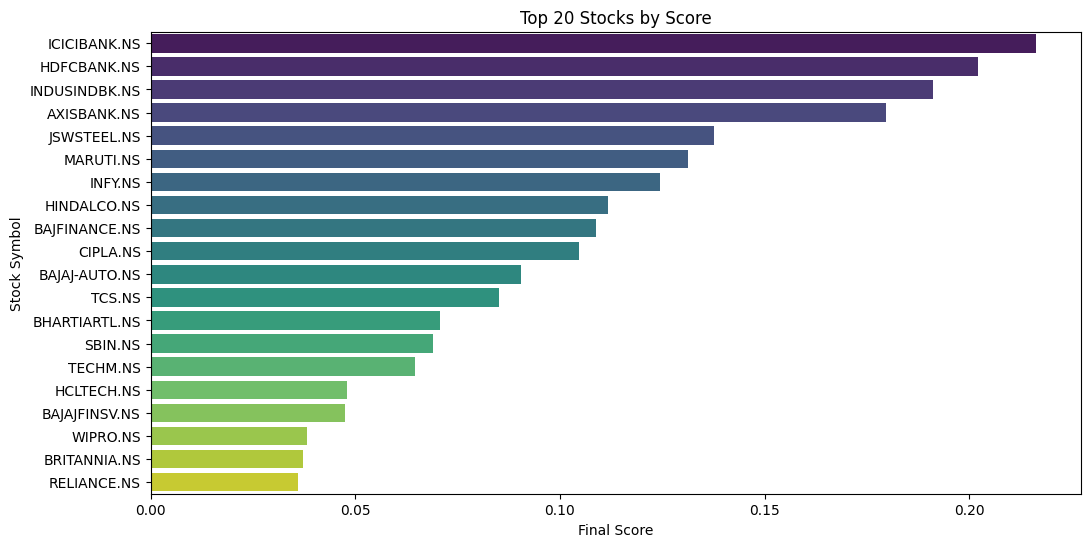

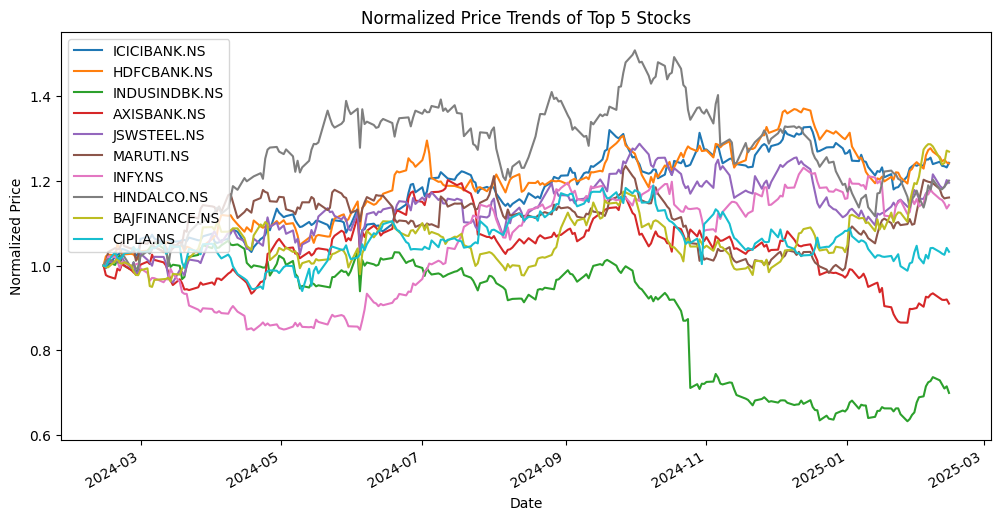

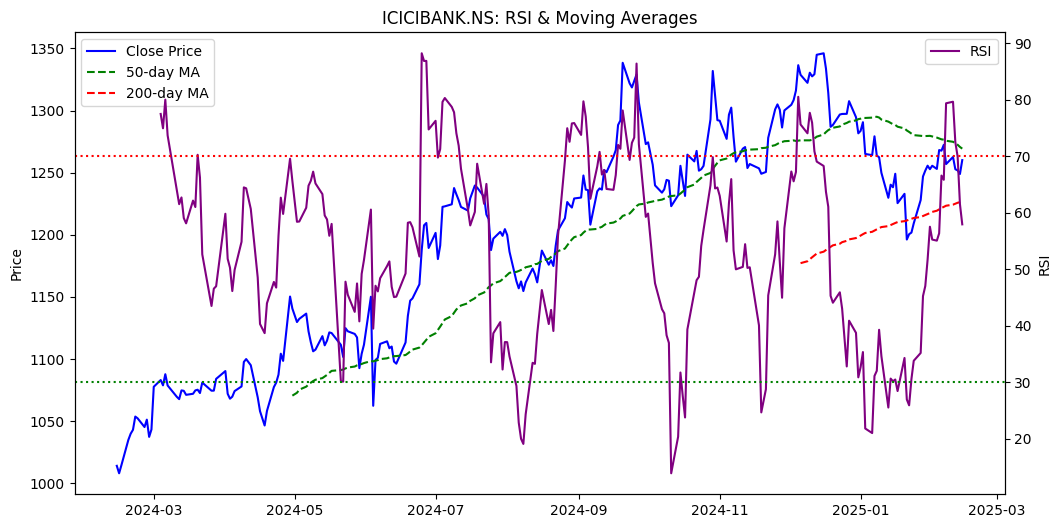

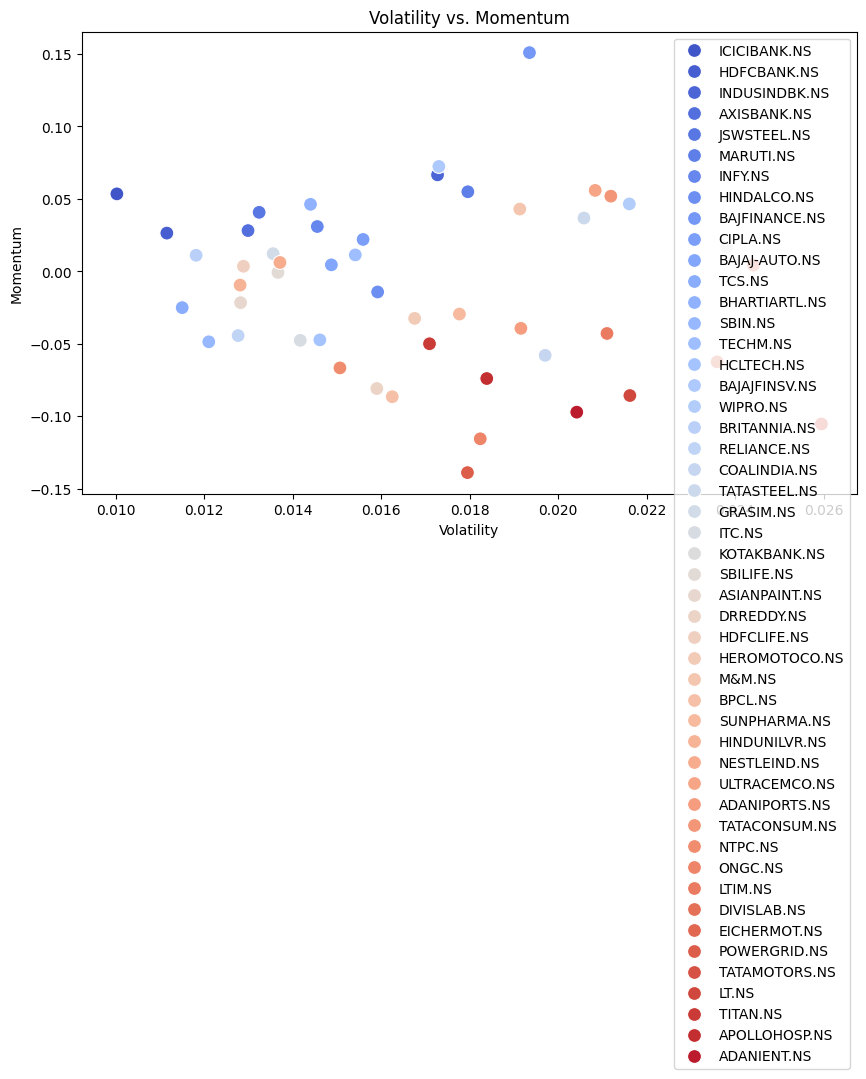

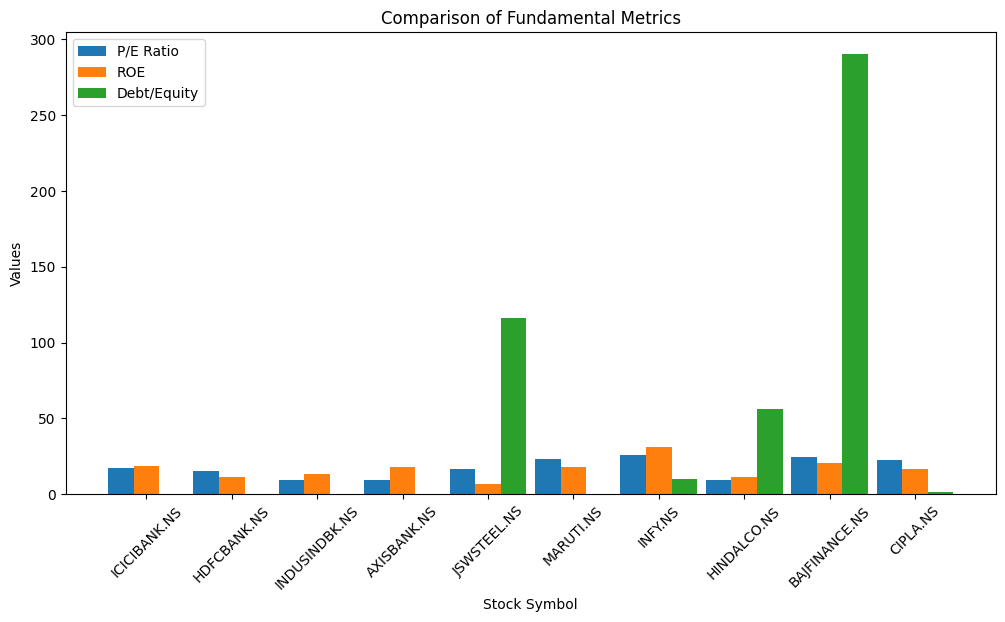

In [ ]:
if __name__ == "__main__":
    top_stocks,selector = main()
    visualize(selector, top_stocks)

# Dynamic Portfolio Optimization and Calculation Functions

Stock Data

In [ ]:
def stock_data(tickers, start_date, end_date):
    """Fetch stock price data"""
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    return data

Optimal Weights Calculation

Algorithm Used -> Hierarchical Clustering + MVO Optimization

In [ ]:
def compute_dynamic_portfolio_weights_1(data, lookback_window=252, rebalance_interval=120, num_clusters=2):
    """
    Compute dynamic portfolio weights with hierarchical clustering and specified rebalancing interval

    Parameters:
    - data: DataFrame of stock prices
    - lookback_window: Days for historical optimization
    - rebalance_interval: Number of days between weight recalculations
    - num_clusters: Number of stock clusters

    Returns:
    - Weights DataFrame
    """
    # Initialize weights DataFrame
    weights_df = pd.DataFrame(index=data.index, columns=data.columns)

    # Store previous weights and last rebalance date
    previous_weights = None
    last_rebalance_date = None

    # Iterate through the data, starting from the lookback window
    for i in range(lookback_window, len(data)):
        # Determine if it's time to rebalance
        is_first_iteration = previous_weights is None
        is_rebalance_day = (last_rebalance_date is None or
                            (i - last_rebalance_date >= rebalance_interval))

        # Select historical data for optimization
        historical_data = data.iloc[i-lookback_window:i]

        if is_first_iteration or is_rebalance_day:
            # Compute daily returns
            returns = historical_data.pct_change().dropna()

            # Compute correlation and distance matrix
            correlation = returns.corr()
            distance_matrix = np.sqrt(2 * (1 - correlation))

            # Perform hierarchical clustering
            linked = linkage(distance_matrix, method='ward')

            # Assign cluster labels
            clusters = fcluster(linked, num_clusters, criterion='maxclust')
            tickers = list(returns.columns)
            cluster_map = {tickers[j]: clusters[j] for j in range(len(tickers))}

            # Initialize daily weights
            daily_weights = {}

            # Cluster-level weights to ensure total portfolio weight is 1
            cluster_level_weights = {j: 1/num_clusters for j in range(1, num_clusters + 1)}

            # Optimize weights within each cluster
            for cluster_id in range(1, num_clusters + 1):
                # Find stocks in this cluster
                cluster_stocks = [stock for stock, cluster in cluster_map.items() if cluster == cluster_id]

                if not cluster_stocks:
                    continue

                # Select cluster data
                cluster_data = historical_data[cluster_stocks]

                # Calculate mean returns and covariance matrix
                mean_returns = mean_historical_return(cluster_data)
                cov_matrix = CovarianceShrinkage(cluster_data).ledoit_wolf()

                def calculate_weights(ret_bl, S_bl, cluster_weight):
                    # List of optimization strategies to try
                    strategies = [
                        lambda ef: ef.max_sharpe(risk_free_rate=0),
                        lambda ef: ef.min_volatility(),
                        lambda ef: ef.max_quadratic_utility(risk_aversion=1),
                        lambda ef: ef.min_volatility()  # Fallback with different solver
                    ]

                    for strategy in strategies:
                        try:
                            ef = EfficientFrontier(ret_bl, S_bl)
                            ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # Added L2 regularization

                            # Try different solvers if default fails
                            try:
                                strategy(ef)
                            except:
                                # Try with alternative solver
                                ef = EfficientFrontier(ret_bl, S_bl, solver="SCS")
                                strategy(ef)

                            weights = ef.clean_weights()

                            # Scale weights to match the cluster-level allocation
                            total_cluster_weight = sum(weights.values())
                            if total_cluster_weight > 0:  # Ensure we don't divide by zero
                                scaled_weights = {k: v * cluster_weight / total_cluster_weight
                                               for k, v in weights.items()}
                                return scaled_weights
                        except:
                            continue

                    # If all optimization attempts fail, return equal weights
                    n_assets = len(ret_bl)
                    equal_weights = {asset: cluster_weight / n_assets for asset in ret_bl.index}
                    return equal_weights

                # Use the pre-determined cluster-level weight for this cluster
                cluster_level_weight = cluster_level_weights[cluster_id]
                cluster_weights = calculate_weights(mean_returns, cov_matrix, cluster_level_weight)
                daily_weights.update(cluster_weights)

            # Normalize daily weights to ensure they sum to 1
            total_weight = sum(daily_weights.values())
            daily_weights = {k: v/total_weight for k, v in daily_weights.items()}

            # Update previous weights and last rebalance date
            previous_weights = daily_weights
            last_rebalance_date = i
        else:
            # Use previous weights if not rebalancing
            daily_weights = previous_weights

        # Record weights for the current day
        weights_df.iloc[i] = pd.Series(daily_weights)

    # Fill initial NaN weights with zeros
    weights_df = weights_df.fillna(0)

    return weights_df

Algorithm Used -> Black Litterman Model + Hierarchical Clustering

In [ ]:
def get_user_views(tickers):
    """
    Get user input for views on specific stocks while defaulting others to zero
    """
    viewdict = {ticker: 0 for ticker in tickers}  # Initialize all views as zero

    while True:
        try:
            input_tickers = input("\nEnter ticker symbols for stocks you have views on (comma-separated, or press Enter if none): ").strip()
            if input_tickers == "":
                return viewdict

            # Convert input to list of tickers
            input_tickers = [t.strip().upper() for t in input_tickers.split(',')]

            # Validate tickers
            invalid_tickers = [t for t in input_tickers if t not in tickers]
            if invalid_tickers:
                print(f"Invalid tickers: {', '.join(invalid_tickers)}")
                continue

            # Get views for selected tickers
            print("\nEnter expected returns (as decimal) for selected stocks:")
            for ticker in input_tickers:
                while True:
                    try:
                        view = input(f"{ticker}: ")
                        if view.strip():
                            viewdict[ticker] = float(view)
                            break
                        else:
                            print("Please enter a value for this ticker")
                    except ValueError:
                        print("Please enter a valid number")

            return viewdict

        except Exception as e:
            print(f"Error: {str(e)}")
            print("Please try again")

def compute_dynamic_portfolio_weights_2(
    data,
    market_prices,
    mcaps,
    lookback_window=252,
    rebalance_interval=120,
    num_clusters=2,
    initial_capital=1000000
):
    """
    Compute dynamic portfolio weights combining Black-Litterman and hierarchical clustering

    Parameters:
    - data: DataFrame of stock prices
    - market_prices: Series of market index prices
    - mcaps: Dictionary of market capitalizations
    - lookback_window: Days for historical optimization
    - rebalance_interval: Number of days between rebalance
    - num_clusters: Number of stock clusters
    - initial_capital: Initial investment amount

    Returns:
    - Weights DataFrame
    - Allocations DataFrame
    - List of leftover cash after each rebalance
    """
    # Initialize output DataFrames
    weights_df = pd.DataFrame(index=data.index, columns=data.columns)
    allocations_df = pd.DataFrame(index=data.index, columns=data.columns)
    leftover_history = []

    # Store previous values
    previous_weights = None
    previous_allocation = None
    last_rebalance_date = None

    # Initialize views with zeros
    viewdict = {ticker: 0 for ticker in data.columns}

    # Iterate through the data
    for i in range(lookback_window, len(data)):
        # Determine if it's time to rebalance
        is_first_iteration = previous_weights is None
        is_rebalance_day = (last_rebalance_date is None or
                           (i - last_rebalance_date >= rebalance_interval))

        # Select historical data for optimization
        historical_data = data.iloc[i-lookback_window:i]
        historical_market = market_prices.iloc[i-lookback_window:i]

        if is_first_iteration or is_rebalance_day:
            # Get user views for the new period
            print(f"\nRebalancing for date: {data.index[i]}")
            viewdict = get_user_views(data.columns)

            # Compute correlation and distance matrix
            returns = historical_data.pct_change().dropna()
            correlation = returns.corr()
            distance_matrix = np.sqrt(2 * (1 - correlation))

            # Perform hierarchical clustering
            linked = linkage(distance_matrix, method='ward')
            clusters = fcluster(linked, num_clusters, criterion='maxclust')

            # Create cluster mapping
            tickers = list(returns.columns)
            cluster_map = {tickers[j]: clusters[j] for j in range(len(tickers))}

            # Initialize daily weights
            daily_weights = {}

            # Calculate Black-Litterman parameters
            S = risk_models.CovarianceShrinkage(historical_data).ledoit_wolf()
            delta = black_litterman.market_implied_risk_aversion(historical_market)
            market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

            # Initialize cluster-level weights
            cluster_level_weights = {j: 1/num_clusters for j in range(1, num_clusters + 1)}

            # Optimize within each cluster
            for cluster_id in range(1, num_clusters + 1):
                cluster_stocks = [stock for stock, cluster in cluster_map.items() if cluster == cluster_id]

                if not cluster_stocks:
                    continue

                # Select cluster data and views
                cluster_data = historical_data[cluster_stocks]
                cluster_mcaps = {k: mcaps[k] for k in cluster_stocks}
                cluster_views = {k: viewdict[k] for k in cluster_stocks}

                # Compute cluster-specific Black-Litterman model
                cluster_S = risk_models.CovarianceShrinkage(cluster_data).ledoit_wolf()
                cluster_delta = black_litterman.market_implied_risk_aversion(historical_market)
                cluster_prior = black_litterman.market_implied_prior_returns(cluster_mcaps, cluster_delta, cluster_S)

                bl = BlackLittermanModel(cluster_S, pi=cluster_prior, absolute_views=cluster_views)
                ret_bl = bl.bl_returns()

                def calculate_weights(ret_bl, S_bl, cluster_weight):
                    strategies = [
                        lambda ef: ef.max_sharpe(risk_free_rate=0),
                        lambda ef: ef.min_volatility(),
                        lambda ef: ef.max_quadratic_utility(risk_aversion=1)
                    ]

                    for strategy in strategies:
                        try:
                            ef = EfficientFrontier(ret_bl, S_bl)
                            ef.add_objective(objective_functions.L2_reg, gamma=0.1)
                            strategy(ef)
                            weights = ef.clean_weights()

                            # Scale weights to match cluster allocation
                            total_cluster_weight = sum(weights.values())
                            if total_cluster_weight > 0:
                                scaled_weights = {k: v * cluster_weight / total_cluster_weight
                                               for k, v in weights.items()}
                                return scaled_weights
                        except:
                            continue

                    # Fallback to equal weights
                    n_assets = len(ret_bl)
                    return {asset: cluster_weight / n_assets for asset in ret_bl.index}

                # Calculate cluster weights
                cluster_level_weight = cluster_level_weights[cluster_id]
                cluster_weights = calculate_weights(ret_bl, cluster_S, cluster_level_weight)
                daily_weights.update(cluster_weights)

            # Normalize weights
            total_weight = sum(daily_weights.values())
            daily_weights = {k: v/total_weight for k, v in daily_weights.items()}

            # Calculate discrete allocation
            da = DiscreteAllocation(daily_weights,
                                  historical_data.iloc[-1],
                                  total_portfolio_value=initial_capital)
            allocation, leftover = da.lp_portfolio()

            # Ensure all stocks are in allocation dict
            for stock in daily_weights:
                if stock not in allocation:
                    allocation[stock] = 0

            # Update tracking variables
            previous_weights = daily_weights
            previous_allocation = allocation
            last_rebalance_date = i
            leftover_history.append((data.index[i], leftover))

        else:
            # Use previous values if not rebalancing
            daily_weights = previous_weights
            allocation = previous_allocation

        # Record weights and allocations
        weights_df.iloc[i] = pd.Series(daily_weights)
        allocations_df.iloc[i] = pd.Series(allocation)

    # Fill initial NaN values
    weights_df = weights_df.fillna(0)
    allocations_df = allocations_df.fillna(0)

    return weights_df

Algorithm Used -> Hierarchical Risk Parity + Clustering Optimization

In [ ]:
import riskfolio as rp

In [ ]:
def compute_dynamic_portfolio_weights_3(data, lookback_window=252, rebalance_interval=90, num_clusters=2):
    """
    Compute dynamic portfolio weights using HRP with clustering

    Parameters:
    - data: DataFrame of stock prices
    - lookback_window: Days for historical optimization
    - rebalance_interval: Number of days between weight recalculations
    - num_clusters: Number of stock clusters

    Returns:
    - Weights DataFrame
    """
    def get_returns(prices):
        return prices.pct_change().dropna()

    def cluster_assets(returns, num_clusters=num_clusters): # Added num_clusters as a parameter
        correlation = returns.corr()
        distance_matrix = np.sqrt(2 * (1 - correlation))
        linked = linkage(distance_matrix, method='ward')
        clusters = fcluster(linked, num_clusters, criterion='maxclust')

        cluster_map = {}
        for i, cluster_id in enumerate(clusters):
            if cluster_id not in cluster_map:
                cluster_map[cluster_id] = []
            cluster_map[cluster_id].append(returns.columns[i])

        return cluster_map

    def optimize_cluster(returns, assets):
        if len(assets) == 1:
            return pd.Series({assets[0]: 1.0})

        cluster_returns = returns[assets]
        port = rp.HCPortfolio(returns=cluster_returns)

        try:
            w = port.optimization(model='HRP',
                                   codependence='pearson',
                                   covariance='hist')
            return pd.Series(w.to_dict()['weights'])
        except:
            # Fallback to equal weights
            n_assets = len(assets)
            return pd.Series({asset: 1/n_assets for asset in assets})

    # Initialize weights DataFrame
    weights_df = pd.DataFrame(index=data.index, columns=data.columns)

    # Store previous weights and last rebalance date
    previous_weights = None
    last_rebalance_date = None

    # Iterate through the data
    for i in range(lookback_window, len(data)):
        # Determine if it's time to rebalance
        is_first_iteration = previous_weights is None
        is_rebalance_day = (last_rebalance_date is None or
                            (i - last_rebalance_date >= rebalance_interval))

        # Select historical data for optimization
        historical_data = data.iloc[i-lookback_window:i]

        if is_first_iteration or is_rebalance_day:
            # Compute daily returns
            returns = get_returns(historical_data)

            # Cluster assets
            cluster_map = cluster_assets(returns) # Changed to call cluster_assets function directly

            # Initialize daily weights
            daily_weights = {}

            # Optimize weights for each cluster
            for cluster_id, assets in cluster_map.items():
                cluster_weights = optimize_cluster(returns, assets)
                daily_weights.update(cluster_weights.to_dict())

            # Normalize daily weights to ensure they sum to 1
            total_weight = sum(daily_weights.values())
            daily_weights = {k: v/total_weight for k, v in daily_weights.items()}

            # Update previous weights and last rebalance date
            previous_weights = daily_weights
            last_rebalance_date = i
        else:
            # Use previous weights if not rebalancing
            daily_weights = previous_weights

        # Record weights for the current day
        weights_df.iloc[i] = pd.Series(daily_weights)

    # Fill initial NaN weights with zeros
    weights_df = weights_df.fillna(0)

    return weights_df

Backtesting Function

In [ ]:
def portfolio_backtest(weights_df, prices_df, initial_capital=10000000, transaction_cost_per_trade=0.005):
    """
    Perform portfolio backtesting with discrete allocation and transaction costs.
    Returns portfolio performance and trade history.
    """

    # Ensure index alignment
    common_index = weights_df.index.intersection(prices_df.index)
    weights_df = weights_df.loc[common_index]
    prices_df = prices_df.loc[common_index]

    # Ensure all prices columns are in weights, fill missing stocks with zero weight
    for col in prices_df.columns:
        if col not in weights_df.columns:
            weights_df[col] = 0

    # Reorder weights columns to match prices columns
    weights_df = weights_df[prices_df.columns]

    # Initialize tracking variables
    current_capital = initial_capital
    current_positions = {}
    portfolio_history = []
    active_trades = {}
    completed_trades = []

    def discrete_allocation(weights, capital, prices):
        """
        Perform discrete allocation based on weights and current capital.
        """
        weights_dict = weights.to_dict()
        weights_dict = {k: v for k, v in weights_dict.items() if v > 0.001}  # Remove negligible weights
        total_weight = sum(weights_dict.values())
        weights_dict = {k: v / total_weight for k, v in weights_dict.items()}  # Normalize weights

        da = DiscreteAllocation(weights_dict, prices, total_portfolio_value=capital)
        try:
            alloc, leftover = da.lp_portfolio()  # Try linear programming first
        except Exception:
            alloc, leftover = da.greedy_portfolio()  # Fallback to greedy allocation

        for stock in weights.index:
            if stock not in alloc:
                alloc[stock] = 0

        return alloc, leftover

    # Iterate through trading days
    for date in common_index:
        current_weights = weights_df.loc[date]
        current_prices = prices_df.loc[date]

        # Get discrete allocation
        current_allocation, leftover = discrete_allocation(current_weights, current_capital, current_prices)

        transaction_costs = 0
        portfolio_value_change = 0
        total_value_traded = 0

        for stock, new_shares in current_allocation.items():
            prev_shares = current_positions.get(stock, 0)
            current_price = current_prices[stock]

            shares_traded = abs(new_shares - prev_shares)  # Total shares traded
            trade_value = shares_traded * current_price
            total_value_traded += trade_value

            if shares_traded > 0:
                transaction_costs += transaction_cost_per_trade * trade_value  # Value-based transaction cost

            # If selling (closing/reducing position)
            if new_shares < prev_shares:
                shares_sold = prev_shares - new_shares
                if stock in active_trades:
                    entry_data = active_trades[stock]
                    profit_loss = (current_price - entry_data['entry_price']) * shares_sold

                    completed_trades.append({
                        'Stock': stock,
                        'Entry Date': entry_data['entry_date'],
                        'Exit Date': date,
                        'Number of Stocks': shares_sold,
                        'Net Profit/Loss': profit_loss - (transaction_cost_per_trade * trade_value)
                    })

                    # Update remaining active trade if any shares are left
                    if new_shares > 0:
                        active_trades[stock]['shares'] = new_shares
                    else:
                        del active_trades[stock]  # Remove completely if all sold

            # If buying (opening/increasing position)
            if new_shares > prev_shares:
                shares_bought = new_shares - prev_shares
                if stock not in active_trades:
                    active_trades[stock] = {
                        'entry_date': date,
                        'entry_price': current_price,
                        'shares': shares_bought
                    }
                else:
                    # Weighted average price update
                    old_data = active_trades[stock]
                    total_shares = old_data['shares'] + shares_bought
                    avg_price = ((old_data['entry_price'] * old_data['shares']) +
                                (current_price * shares_bought)) / total_shares
                    active_trades[stock] = {
                        'entry_date': old_data['entry_date'],
                        'entry_price': avg_price,
                        'shares': total_shares
                    }

        # Calculate daily portfolio value change
        for stock, shares in current_allocation.items():
            current_price = current_prices[stock]
            prev_price = prices_df.shift(1).loc[date][stock] if date != common_index[0] else current_price
            stock_return = (current_price - prev_price) * shares
            portfolio_value_change += stock_return

        # Deduct transaction costs and update capital
        current_capital += portfolio_value_change - transaction_costs
        current_positions = current_allocation

        # Store daily portfolio history
        portfolio_history.append({
            'Date': date,
            'Portfolio Value': current_capital,
            'Daily Return': portfolio_value_change / initial_capital,
            'Transaction Costs': transaction_costs,
            'Total Value Traded': total_value_traded
        })

    # Close all remaining open trades at last available price
    last_date = common_index[-1]
    last_prices = prices_df.loc[last_date]

    for stock, trade_data in active_trades.items():
        profit_loss = (last_prices[stock] - trade_data['entry_price']) * trade_data['shares']
        trade_value = trade_data['shares'] * last_prices[stock]
        completed_trades.append({
            'Stock': stock,
            'Entry Date': trade_data['entry_date'],
            'Exit Date': last_date,
            'Number of Stocks': trade_data['shares'],
            'Net Profit/Loss': profit_loss - (transaction_cost_per_trade * trade_value)
        })

    # Convert portfolio history to DataFrame
    portfolio_df = pd.DataFrame(portfolio_history).set_index('Date')
    trades_df = pd.DataFrame(completed_trades)

    return portfolio_df, trades_df

Plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

def get_nifty50_data(start_date, end_date):
    nifty50 = yf.download('^NSEI', start=start_date, end=end_date)['Close']
    return nifty50

def plot_portfolio_performance(portfolio_df, weights_df, prices_df, start_date, end_date):
    """
    Create comprehensive visualization of portfolio performance
    """
    sns.set_style('darkgrid')

    # Get Nifty 50 Data
    nifty50 = get_nifty50_data(start_date, end_date)

    # Compute Buy and Hold Portfolio for Nifty 50
    nifty50_bh = (nifty50 / nifty50.iloc[0]) * portfolio_df['Portfolio Value'].iloc[0]

    # 1. Portfolio Value Over Time with Nifty 50 Index and Buy & Hold Portfolio
    plt.figure(figsize=(10, 5))
    plt.title('Portfolio Value vs Nifty 50 Index')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.plot(portfolio_df.index, portfolio_df['Portfolio Value'], label='Portfolio', color='blue')
    # plt.plot(nifty50.index, nifty50, label='Nifty 50 Index', color='red', linestyle='dashed')
    plt.plot(nifty50_bh.index, nifty50_bh, label='Nifty 50 Buy & Hold', color='green', linestyle='dotted')
    plt.legend()
    plt.show()

    # 2. Daily Returns Distribution
    plt.figure(figsize=(10, 5))
    plt.title('Daily Returns Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    portfolio_df['Daily Return'].hist(bins=30, edgecolor='black')
    plt.show()

    # 3. Transaction Costs Over Time
    plt.figure(figsize=(10, 5))
    plt.title('Cumulative Transaction Costs')
    plt.xlabel('Date')
    plt.ylabel('Transaction Costs ($)')
    portfolio_df['Transaction Costs'].plot()
    plt.show()

    # 4. Portfolio Weights Heatmap
    plt.figure(figsize=(10, 5))
    plt.title('Portfolio Weights Heatmap')
    plt.xlabel('Date')
    plt.ylabel('Stocks')
    sns.heatmap(weights_df.T, cmap='YlGnBu', cbar_kws={'label': 'Weight'})
    plt.show()



Portfolio Metrics

In [ ]:
def calculate_portfolio_metrics(portfolio_df, initial_capital):
    """
    Calculate and print key portfolio performance metrics
    """
    # Total Return
    total_return = (portfolio_df['Portfolio Value'].iloc[-1] - initial_capital) / initial_capital * 100

    # Annualized Return
    days = (portfolio_df.index[-1] - portfolio_df.index[0]).days
    years = days / 365
    annualized_return = ((portfolio_df['Portfolio Value'].iloc[-1] / initial_capital) ** (1/years) - 1) * 100

    # Sharpe Ratio
    daily_returns = portfolio_df['Daily Return']
    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

    # Maximum Drawdown
    cumulative_max = portfolio_df['Portfolio Value'].cummax()
    drawdown = (portfolio_df['Portfolio Value'] - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min() * 100

    # Print metrics
    print("Portfolio Performance Metrics:")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Annualized Return: {annualized_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Total Transaction Costs: ${portfolio_df['Transaction Costs'].sum():.2f}")

Select the Top n Stocks

In [ ]:

def get_top_n_stocks(top_stocks):
    """
    Ask the user for the number of top stocks to select and return a list of their tickers.

    Parameters:
    top_stocks (dict): A dictionary with stock tickers as keys and their scores as values.

    Returns:
    list: A list of top stock tickers.
    """
    try:
        n = int(input("Enter the number of top stocks to select: "))
        if n <= 0:
            print("Please enter a positive integer.")
            return []

        # Sort the dictionary based on values in descending order
        sorted_stocks = sorted(top_stocks.items(), key=lambda x: x[1], reverse=True)

        # Extract top n stock tickers
        nse_symbols = [stock[0] for stock in sorted_stocks[:n]]


        return nse_symbols
    except ValueError:
        print("Invalid input. Please enter a valid number.")
        return []

# print("Selected top stocks:", nse_symbols)

Main

Run Optimization


Portfolio Optimization Strategy Selection
1. Strategy 1: Dynamic Portfolio Weights with Clustering
2. Strategy 2: Black-Litterman with Clustering
3. Strategy 3: HRP with Clustering

Select optimization strategy (1, 2, or 3): 1

Enter stock tickers separated by commas (e.g., RELIANCE.NS,TCS.NS) or press Enter for default: 
Enter the start date (YYYY-MM-DD) or press Enter for default date: 
Enter the end date (YYYY-MM-DD) or press Enter for default date: 
Enter the number of top stocks to select: 50
['ICICIBANK.NS', 'HDFCBANK.NS', 'INDUSINDBK.NS', 'AXISBANK.NS', 'JSWSTEEL.NS', 'MARUTI.NS', 'INFY.NS', 'HINDALCO.NS', 'BAJFINANCE.NS', 'CIPLA.NS', 'BAJAJ-AUTO.NS', 'TCS.NS', 'BHARTIARTL.NS', 'SBIN.NS', 'TECHM.NS', 'HCLTECH.NS', 'BAJAJFINSV.NS', 'WIPRO.NS', 'BRITANNIA.NS', 'RELIANCE.NS', 'COALINDIA.NS', 'TATASTEEL.NS', 'GRASIM.NS', 'ITC.NS', 'KOTAKBANK.NS', 'SBILIFE.NS', 'ASIANPAINT.NS', 'DRREDDY.NS', 'HDFCLIFE.NS', 'HEROMOTOCO.NS', 'M&M.NS', 'BPCL.NS', 'SUNPHARMA.NS', 'HINDUNILVR.NS', 'NESTL

[                       0%                       ]


Fetching stock data...


[*********************100%***********************]  49 of 49 completed



Computing portfolio weights...
Using Strategy 1: Dynamic Portfolio Weights with Clustering

Performing portfolio backtesting...


[*********************100%***********************]  1 of 1 completed


Calculating portfolio metrics...
Portfolio Performance Metrics:
Total Return: 51.65%
Annualized Return: 27.14%
Sharpe Ratio: 2.07
Maximum Drawdown: -11.37%
Total Transaction Costs: $1238531.13

Generating performance plots...


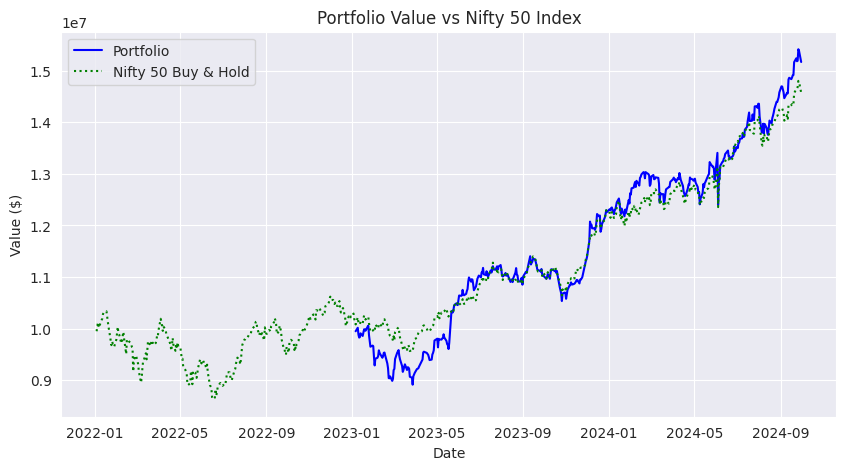

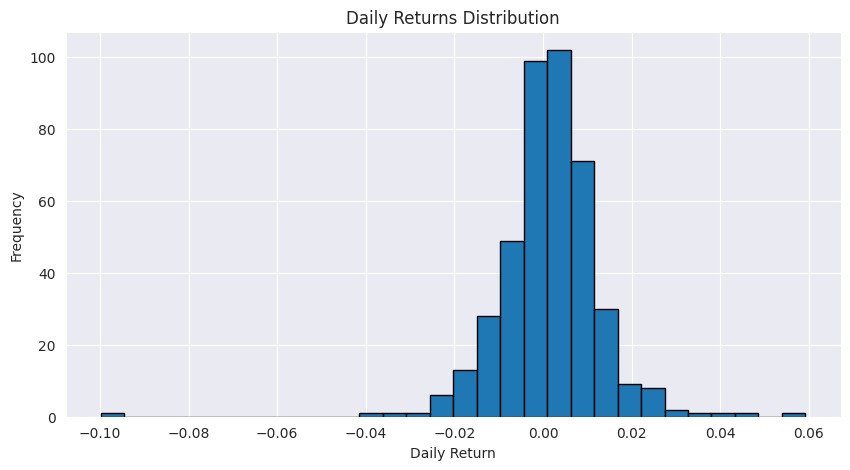

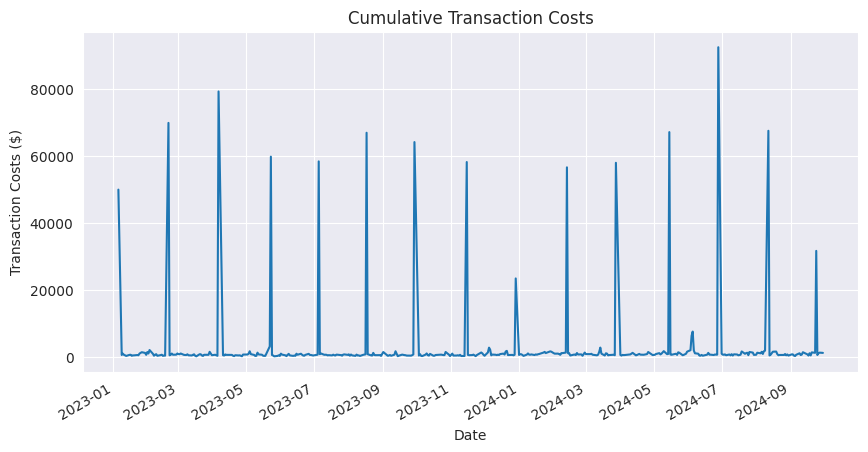

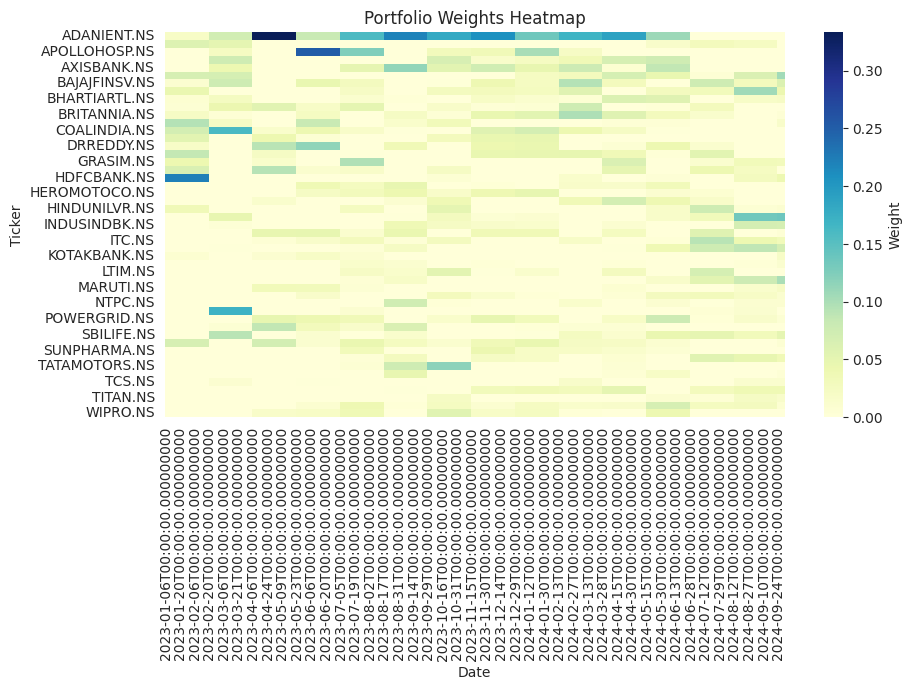


Optimization complete!

Results available in portfolio_df, trades_df, and weights variables


In [ ]:
def main():
    """
    Main execution function for portfolio optimization with user input options
    """
    # Prompt user for input
    print("\nPortfolio Optimization Strategy Selection")
    print("1. Strategy 1: Dynamic Portfolio Weights with Clustering")
    print("2. Strategy 2: Black-Litterman with Clustering")
    print("3. Strategy 3: HRP with Clustering")

    while True:
        strategy = input("\nSelect optimization strategy (1, 2, or 3): ").strip()
        if strategy in ['1', '2', '3']:
            break
        print("Invalid selection. Please enter 1, 2, or 3.")

    user_tickers = input("\nEnter stock tickers separated by commas (e.g., RELIANCE.NS,TCS.NS) or press Enter for default: ").strip()
    start_date_input = input("Enter the start date (YYYY-MM-DD) or press Enter for default date: ").strip()
    end_date_input = input("Enter the end date (YYYY-MM-DD) or press Enter for default date: ").strip()

    nse_symbols = get_top_n_stocks(top_stocks)
    print(nse_symbols)

    # Default settings
    default_tickers = nse_symbols
    default_start_date = '2022-01-01'
    default_end_date = '2024-10-01'

    # Process tickers
    tickers = user_tickers.split(',') if user_tickers else default_tickers
    tickers = [t.strip() for t in tickers]

    # Validate and convert dates
    start_date = start_date_input if start_date_input else default_start_date
    end_date = end_date_input if end_date_input else default_end_date

    # Additional parameters
    print("\nOptimization Parameters:")
    try:
        lookback_window = int(input("Enter lookback window (days) or press Enter for default (252): ") or 252)
        rebalance_interval = int(input("Enter rebalance interval (days) or press Enter for default (90): ") or 90)
        num_clusters = int(input("Enter number of clusters or press Enter for default (2): ") or 2)
        initial_capital = float(input("Enter initial capital or press Enter for default (10000000): ") or 10000000)
    except ValueError:
        print("Invalid input. Using default values.")
        lookback_window = 252
        rebalance_interval = 90
        num_clusters = 2
        initial_capital = 10000000

    # Fetch stock data
    print("\nFetching stock data...")
    data = stock_data(tickers, start_date, end_date)

    if strategy in ['2', '3']:
        # Get market data for strategies 2 and 3
        print("Fetching market data...")
        market_prices = yf.download('^NSEI', start_date, end_date)['Close']
        market_prices = market_prices[market_prices.index.isin(data.index)].copy()

        # Get market caps
        print("Fetching market caps...")
        mcaps = {}
        for t in tickers:
            try:
                stock = yf.Ticker(t)
                mcaps[t] = stock.info.get('marketCap', 1000000000)
            except:
                print(f"Warning: Could not fetch market cap for {t}. Using default value.")
                mcaps[t] = 1000000000

    # Compute dynamic portfolio weights based on selected strategy
    print("\nComputing portfolio weights...")
    if strategy == '1':
        print("Using Strategy 1: Dynamic Portfolio Weights with Clustering")
        thresholded_weights = compute_dynamic_portfolio_weights_1(
            data,
            lookback_window=lookback_window,
            rebalance_interval=rebalance_interval,
            num_clusters=num_clusters
        )
    elif strategy == '2':
        print("Using Strategy 2: Black-Litterman with Clustering")
        thresholded_weights = compute_dynamic_portfolio_weights_2(
            data,
            market_prices,
            mcaps,
            lookback_window=lookback_window,
            rebalance_interval=rebalance_interval,
            num_clusters=num_clusters
        )
    else:
        print("Using Strategy 3: HRP with Clustering")
        thresholded_weights = compute_dynamic_portfolio_weights_3(
            data,
            lookback_window=lookback_window,
            rebalance_interval=rebalance_interval,
            num_clusters=num_clusters
        )

    # Remove initial lookback period
    thresholded_weights = thresholded_weights.iloc[lookback_window:]

    # Perform portfolio backtesting
    print("\nPerforming portfolio backtesting...")
    portfolio_df, trades_df = portfolio_backtest(thresholded_weights, data, initial_capital)

    # Calculate and print portfolio metrics
    print("\nCalculating portfolio metrics...")
    calculate_portfolio_metrics(portfolio_df, initial_capital)

    # Plot portfolio performance
    print("\nGenerating performance plots...")
    plot_portfolio_performance(portfolio_df, thresholded_weights, data, start_date, end_date)

    print("\nOptimization complete!")
    return portfolio_df, trades_df, thresholded_weights

if __name__ == "__main__":
  portfolio_df, trades_df, weights = main()
  print("\nResults available in portfolio_df, trades_df, and weights variables")
    # except Exception as e:
    #     print(f"\nAn error occurred: {str(e)}")
    #     print("Please check your inputs and try again.")

# History

Trade History

In [ ]:
trades_df

,Stock,Entry Date,Exit Date,Number of Stocks,Net Profit/Loss
0,HDFCBANK.NS,2023-01-06,2023-01-09,10,-47.671173
1,CIPLA.NS,2023-01-06,2023-01-09,13,71.814852
2,EICHERMOT.NS,2023-01-06,2023-01-09,3,-12.804459
3,COALINDIA.NS,2023-01-06,2023-01-09,31,-9.913394
4,SBIN.NS,2023-01-06,2023-01-09,19,73.531763
...,...,...,...,...,...
4344,CIPLA.NS,2024-09-24,2024-09-30,155,1297.857393
4345,SBIN.NS,2024-09-24,2024-09-30,141,-1997.840249
4346,INFY.NS,2024-09-24,2024-09-30,41,-1297.866368
4347,TATASTEEL.NS,2024-09-24,2024-09-30,390,2775.413992


Portfolio History

In [ ]:
portfolio_df

,Portfolio Value,Daily Return,Transaction Costs,Total Value Traded
Date,,,,
2023-01-06,9.950000e+06,0.000000,49999.635260,9.999927e+06
2023-01-09,1.001760e+07,0.006822,615.565017,1.231130e+05
2023-01-10,9.884919e+06,-0.013166,1021.103010,2.042206e+05
2023-01-11,9.827906e+06,-0.005636,655.384528,1.310769e+05
2023-01-12,9.836798e+06,0.000941,516.438754,1.032878e+05
...,...,...,...,...
2024-09-24,1.518027e+07,-0.002408,31706.281942,6.341256e+06
2024-09-25,1.518891e+07,0.000925,612.044124,1.224088e+05
2024-09-26,1.541254e+07,0.022477,1142.461193,2.284922e+05


Weights History

In [ ]:
weights

Ticker,ADANIENT.NS,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,BPCL.NS,...,SBIN.NS,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,WIPRO.NS
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-06,0.019816,0.059826,0.0,0.0,0.0,0.066709,0.009253,0.045360,0.008837,0.007333,...,0.067377,0.0,0.000000,0.0,0.000000,0.000887,0.000000,0.000000,0.000000,0.0
2023-01-09,0.019816,0.059826,0.0,0.0,0.0,0.066709,0.009253,0.045360,0.008837,0.007333,...,0.067377,0.0,0.000000,0.0,0.000000,0.000887,0.000000,0.000000,0.000000,0.0
2023-01-10,0.019816,0.059826,0.0,0.0,0.0,0.066709,0.009253,0.045360,0.008837,0.007333,...,0.067377,0.0,0.000000,0.0,0.000000,0.000887,0.000000,0.000000,0.000000,0.0
2023-01-11,0.019816,0.059826,0.0,0.0,0.0,0.066709,0.009253,0.045360,0.008837,0.007333,...,0.067377,0.0,0.000000,0.0,0.000000,0.000887,0.000000,0.000000,0.000000,0.0
2023-01-12,0.019816,0.059826,0.0,0.0,0.0,0.066709,0.009253,0.045360,0.008837,0.007333,...,0.067377,0.0,0.000000,0.0,0.000000,0.000887,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24,0.000000,0.000000,0.0,0.0,0.0,0.104211,0.061830,0.044008,0.020976,0.000000,...,0.007273,0.0,0.035337,0.0,0.004283,0.012653,0.038007,0.016117,0.009093,0.0
2024-09-25,0.000000,0.000000,0.0,0.0,0.0,0.104211,0.061830,0.044008,0.020976,0.000000,...,0.007273,0.0,0.035337,0.0,0.004283,0.012653,0.038007,0.016117,0.009093,0.0
2024-09-26,0.000000,0.000000,0.0,0.0,0.0,0.104211,0.061830,0.044008,0.020976,0.000000,...,0.007273,0.0,0.035337,0.0,0.004283,0.012653,0.038007,0.016117,0.009093,0.0
